# CS4168 Data Mining

Aoife Kennedy

Lab 4: Comparison of Binary Classifiers

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
#from scipy import interp
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

## EDA - Exploratory Data Analysis

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = "/content/drive/MyDrive/seeds.csv"
df = pd.read_csv(path)
df.head()

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,type
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


In [5]:
df.tail()

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,type
205,12.19,13.20,0.8783,5.137,2.981,3.631,4.870,3
206,11.23,12.88,0.8511,5.140,2.795,4.325,5.003,3
207,13.20,13.66,0.8883,5.236,3.232,8.315,5.056,3
208,11.84,13.21,0.8521,5.175,2.836,3.598,5.044,3
209,12.30,13.34,0.8684,5.243,2.974,5.637,5.063,3


In [6]:
#Target Type Column
df['type'].value_counts()

1    70
2    70
3    70
Name: type, dtype: int64

In [7]:
#Check for missing values
df.isna().sum()

area                       0
perimeter                  0
compactness                0
length of kernel           0
width of kernel            0
asymmetry coefficient      0
length of kernel groove    0
type                       0
dtype: int64

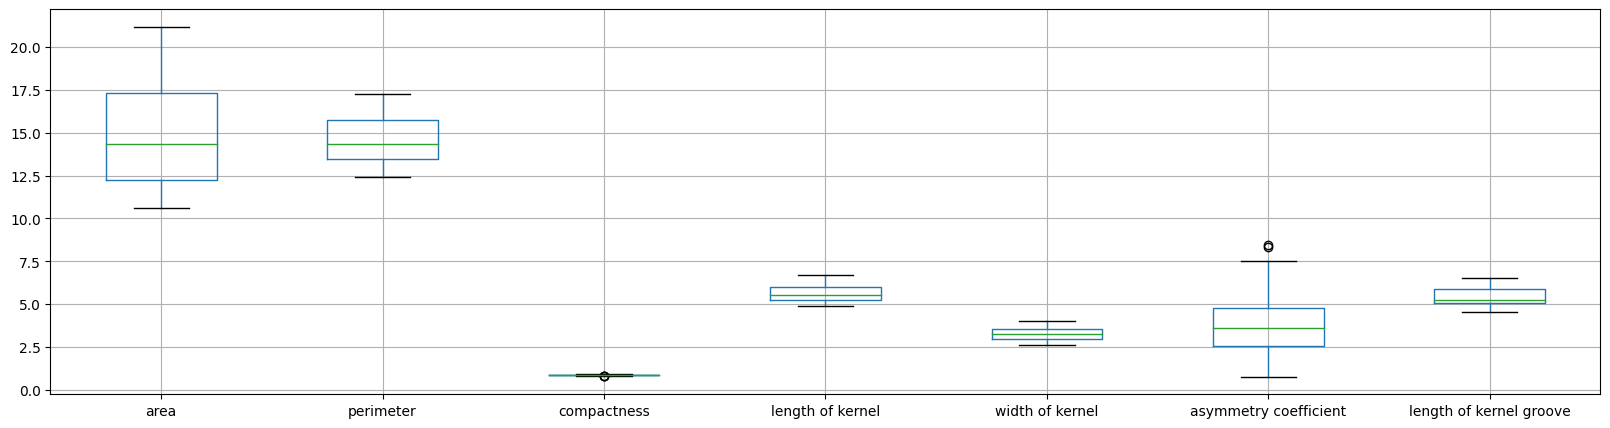

In [8]:
#create a box plot to check for outliers.
df.loc[:,'area':'length of kernel groove'].boxplot(figsize=(20,5))
plt.show()

## Data Preparation

In [9]:
mapper = {1: 1, 2: 0, 3: 0}
df['type'] = df['type'].replace(mapper)
df['type'].value_counts()

0    140
1     70
Name: type, dtype: int64

In [10]:
# store a list with the names of all predictors
names_all = [c for c in df if c not in ['type']]
print(names_all)

# define column groups with same data preparation
names_no_outliers = list(set(names_all))

['area', 'perimeter', 'compactness', 'length of kernel', 'width of kernel', 'asymmetry coefficient', 'length of kernel groove']


In [11]:
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

In [12]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]

In [14]:
preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=names_all),
    FeatureUnion(transformer_list=[
        ("no_outlier_columns", make_pipeline(
            ColumnSelector(columns=names_no_outliers),
            StandardScaler()
        ))
    ])
)

In [15]:
y = df['type']
X = df.drop('type', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

## Grid Search for Best Parameters of Classifiers

In [16]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('svm', svm.SVC(probability=True))])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of svn.SVC and their possible values

param_grid = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': [1, 0.1, 0.01, 0.001],
    'svm__kernel': ['rbf', 'linear', 'poly']}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train) #trainign happens here! SVM is trained 240 times

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_

Best CV score = 0.940:
Best parameters:  {'svm__C': 100, 'svm__gamma': 1, 'svm__kernel': 'linear'}


## Random Forest Classifier

In [17]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('rf', RandomForestClassifier())])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of RandomForestClassifier and their possible values
param_grid = {
    'rf__n_estimators' : [10,20,30],
    'rf__max_depth': [2, 4, 6, 8]
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.910:
Best parameters:  {'rf__max_depth': 4, 'rf__n_estimators': 20}


## MLP

In [18]:
perceptron_classifier = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=1000,activation = 'relu',solver='adam',random_state=1)

#Fitting the training data to the network
mlp_model = perceptron_classifier.fit(X_train, y_train)

## Compare Classifiers on Test Set

In [19]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

In [20]:
# model - a trained binary probabilistic classification model;
#         it is assumed that there are two classes: 0 and 1
#         and the classifier learns to predict probabilities for the examples to belong to class 1

def evaluate_model(X_test, y_test, model):
    # compute probabilistic predictiond for the evaluation set
    _probabilities = model.predict_proba(X_test)[:, 1]

    # compute exact predictiond for the evaluation set
    _predicted_values = model.predict(X_test)

    # compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)

    # compute precision, recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])

    # compute fpr and tpr values for various thresholds
    # by comparing the true target values to the predicted probabilities for class 1
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)

    # compute true positive rates for the values in the array mean_fpr
    _tpr_transformed = np.array([np.interp(mean_fpr, _fpr, _tpr)])

    # compute the area under the curve
    _auc = auc(_fpr, _tpr)

    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

In [21]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test, y_test, SVM_best_model)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc  = evaluate_model(X_test, y_test, RF_best_model)
MLP_accuracy, MLP_precision, MLP_recall, MLP_f1_score, MLP_tpr, MLP_auc = evaluate_model(X_test, y_test, mlp_model)

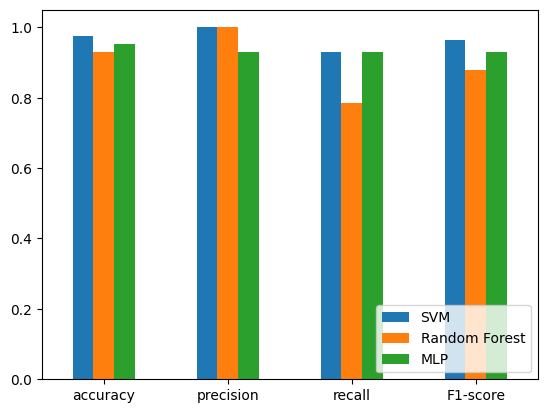

In [22]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
MLP_metrics = np.array([MLP_accuracy, MLP_precision, MLP_recall, MLP_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics, 'MLP': MLP_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

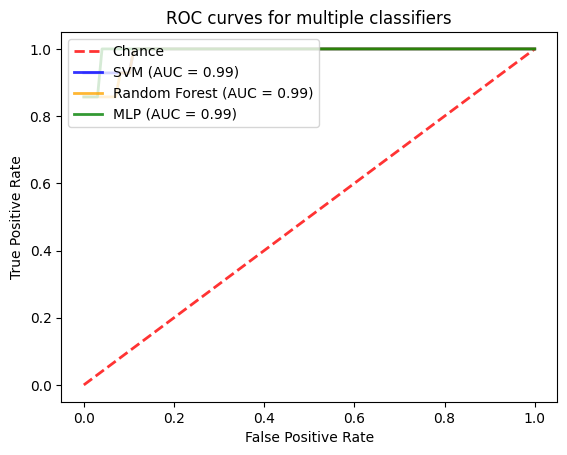

In [23]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.plot(mean_fpr, MLP_tpr[0,:], lw=2, color='green', label='MLP (AUC = %0.2f)' % (MLP_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="upper left")
plt.show()

## Train the Final Model

In [24]:
final_model =perceptron_classifier.fit(X, y)

In [25]:
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))